# Project 2 QuantFund

# Bonus Question 2 : More Considerations in the Trading Simulation

This file shows the analysis of comparing the simulation results when taking different considerations in reality into considration. In order to facilitate the comparison, we first fit and simulate the linear regression provided by TA. 

In [1]:
import pandas as pd
import os
from scipy import stats
import numpy as np
from os import listdir

In [29]:
csv_path = "0 Data/"
stockclose = "StockClosePrice"
indexclose = "IndexClosePrice"

forward_day = 5 # this should depend on your rolling period

# calculate the forward returns
stock = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True)
stockforward = stock.shift(periods = -forward_day, freq = None, axis = 0)
# 5Dforward(t) = (close_price(t+5)-close_price(t))/close_price(t)
stockforwardreturn = (stockforward - stock) / stock
print(stockforwardreturn.head())
stockforwardreturn.to_csv(os.path.join(csv_path, '5DForward.csv')) #stock

# In the simulation, 
# you should also calculate indices returns, 
# and hedge your portfolio with any one of them.
index = pd.read_csv(csv_path + indexclose + ".csv", index_col = 0, parse_dates = True)
indexforward = index.shift(periods = -forward_day, freq = None, axis = 0)
indexforwardreturn = (indexforward - index) / index
print(indexforwardreturn.head())
indexforwardreturn.to_csv(os.path.join(csv_path, 'mkt_5DForward.csv')) #mkt

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2007-01-04   0.047482   0.061368   0.088638   0.186231   0.065688   0.122858   
2007-01-05   0.188363   0.084177   0.094316   0.107551  -0.016348   0.037043   
2007-01-08   0.219149   0.158273   0.103618   0.111985   0.006898   0.031495   
2007-01-09   0.233333   0.230769   0.096691   0.135329   0.075422   0.031128   
2007-01-10   0.208806   0.006994   0.083142   0.096759  -0.043272   0.007674   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2007-01-04   0.250000   0.125307        0.0   0.128390  ...        NaN   
2007-01-05   0.122891   0.073622        0.0   0.079454  ...        NaN   
2007-01-08   0.140277   0.086213        0.0   0.092567  ...        NaN   
2007-01-09   0.130120   0.044423        0.0   0.123708  ...        Na

In [30]:
temp=pd.read_csv("temp.csv", index_col=0)

In [32]:
#list all the factors
factors = ['return']
for i in range(len(factor_list)):
    factors.append(factor_list[i][:-4])

#match the data of return and factor 切掉08年之前的
return_cut = stockforwardreturn[dfs[0].columns][dfs[0].index[0]:dfs[0].index[-1]]

In [33]:
data1 = temp.dropna(subset=['return'])

data1.isnull().sum()

# to balance the number of factors and the size of dataset, 
# drop the factors with missing value more that 10000000
# then drop the missing values for factors left
core_factors = data1.isnull().sum()[data1.isnull().sum()<1000000].index
data = data1[core_factors].dropna()

## Training Factors: Linear Regression

In [34]:
from sklearn import linear_model

#data = temp.dropna()

X = data.drop(['return'], axis=1)
Y = data['return']

model = linear_model.LinearRegression()
model.fit(X, Y)

yhat=data[['return']].copy()
yhat['return']=model.predict(X)

temp1=temp[['return']].join(yhat,lsuffix=1)[['return']]

for i in range(return_cut.shape[1]):
    if i == 0:
        factors_reg = temp1[0:return_cut.shape[0]] 
        factors_reg.insert(0,'date',return_cut.index)
        factors_reg.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_reg = pd.concat([factors_reg,temp2],axis=1)

factors_reg.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/0 new_factors/'
factors_reg.to_csv(os.path.join(save_result_path, 'Linear_Reg_factor.csv'))

# Backtesting Simulation: linear regression

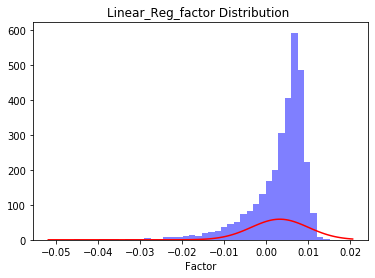

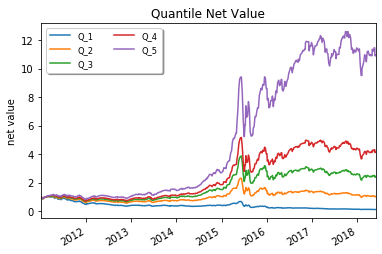

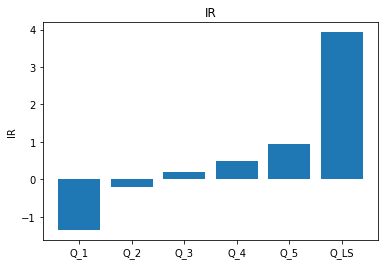

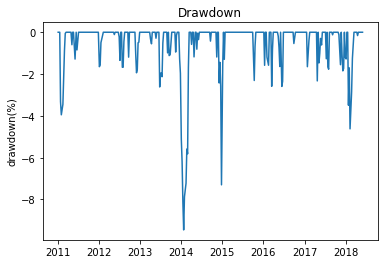

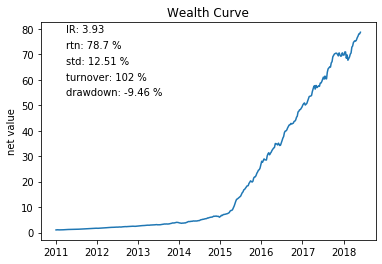

In [35]:
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "Linear_Reg_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

# Trading Cost

In reality, each trade, either long or short, could charge a percentage fee of trading volume. Here we would like to use 0.002 as the percentage cost of trading. The way we apply this act into our model is to add a cost coefficient to return. 

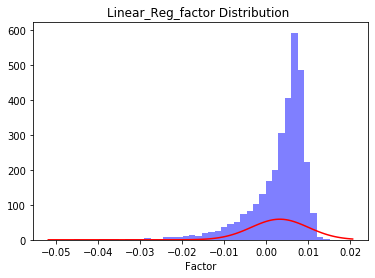

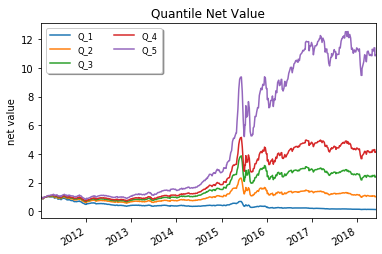

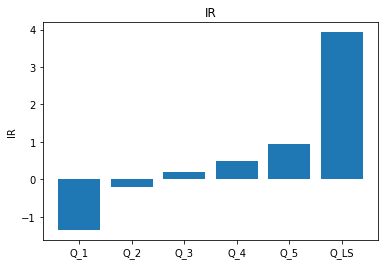

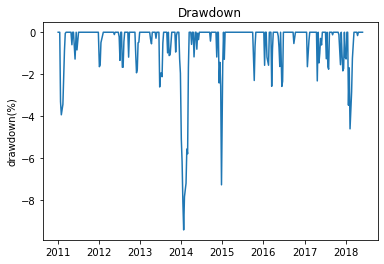

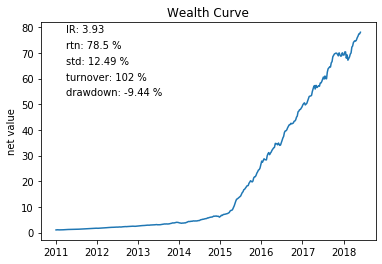

In [44]:
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "Linear_Reg_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn*0.998,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

According to the rtn shown in the wealth curve graph, we see that the return with a 0.2% trading cost is slightly lower than the benchmark( which has no cost at all).

But we can interpret that trading cost will play an important role in return if we change more frequently. 

# Shorting constraints

Assume we cannot short any stock at all, so we delete the “ Long-short constraint” by setting  Type1 = "L"(which is against the default setting in the backtestlite.py)

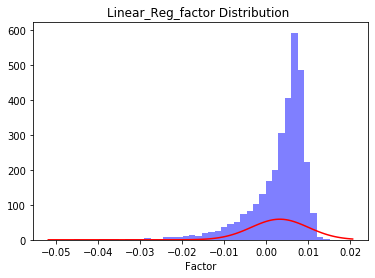

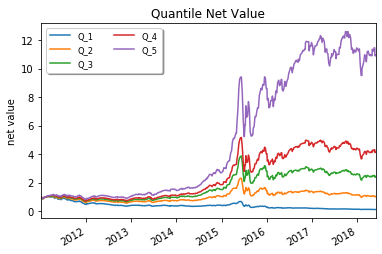

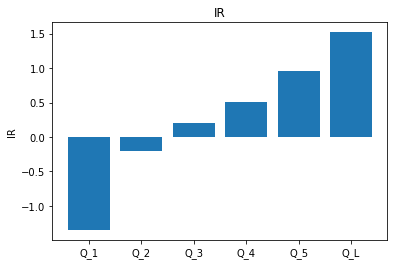

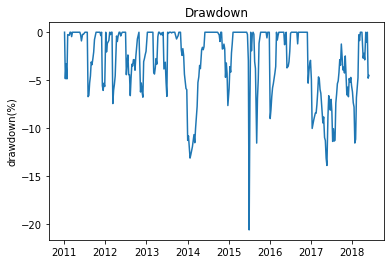

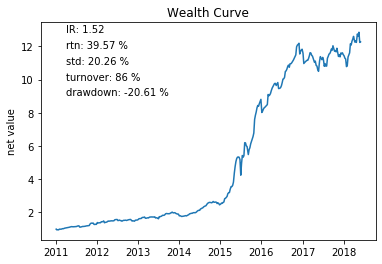

In [36]:
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "Linear_Reg_factor"

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "L"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

Refer to IR diagram, we can see an overall move down in IR compared with long-short strategy, which means that the investment is exposed to a higher level of return variance and thus more risk if not use the long-short strategy.

Given the drawdown diagram, there’s a dramatic decrease in the MaxDrawDown index , which is a sign of a great volatility in assets’ value and implies how great the cost is when unhedgeable constraints  are in presence. 

To summarize, long-short investment strategy can help investors avoid risk to some extent and further facilitate the pricing of assets.

# Trading Feasibility


In most cases, when the stock reaches its limit (+10% or -10%) right after the opening, investors have little chance to make moves. In order to apply this constraint into our model, we add a parameter-lambda in ‘statuslimit’ to restrict transactions if the stock reaches its limit.

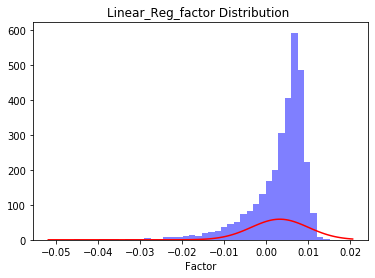

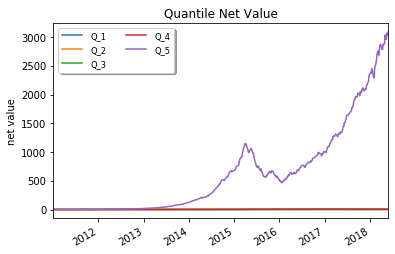

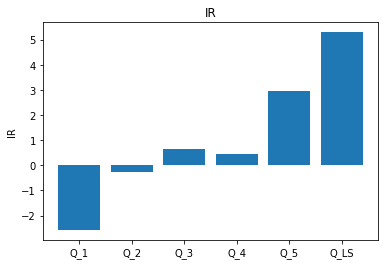

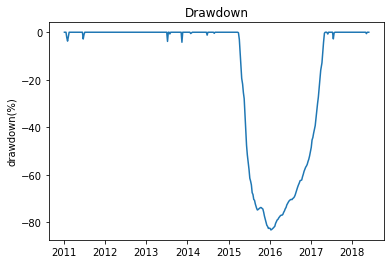

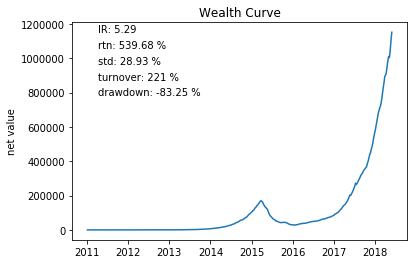

In [45]:
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency5天一次？), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return."SH000905" 中证500
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit=pd.DataFrame(fwdrtn, index = fwdrtn.index, columns =fwdrtn.columns).applymap(lambda x: x*0 if x>0.1 or x<-0.1 else x)

#创建一个和fwdrtn行列标题相同，但全部都是1的DataFrame
#这里面status和statuslimit 的标准是一样


# Revise the factor name (name of .csv file)
factor =  "Linear_Reg_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py


#Backtest 自己建的singlefactor的性能
def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)


It is quite obvious that with the trading limitation, IR is much higher than before( 5.29 compared with 3.91), which is very understandable since large changes are limited, which lead to lower return variance.

The same conclusion can be drawn from the drawdown graph. With limitation, the curve is significantly smoother and looks like a  straight  line in general. 


Compared with other trading conditions, the daily fluctuation limit smooths the vicissitudes wealth curve and hence stabilizes the market overall performance, proving its importance as a safeguard  against speculation.  


# Trading Frequency-2 days

To see how trading frequency affect return, we would like to rerun the model with 2-days-forward and see what happen. Since now we only have the 5DForward data. We first have to prepare and clean the data again to generate the 2-day-forward return in csv file. Here we will simply change the day-index and reorganize the data into 'temp2.csv'.

## Preparation: Calculate the forward returns for stocks and market indices

In [2]:
csv_path = "0 Data/"
stockclose = "StockClosePrice"
indexclose = "IndexClosePrice"

forward_day = 2 # this should depend on your rolling period

# calculate the forward returns
stock = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True)
stockforward2 = stock.shift(periods = -forward_day, freq = None, axis = 0)
# 2Dforward(t) = (close_price(t+2)-close_price(t))/close_price(t)
stockforwardreturn2 = (stockforward2 - stock) / stock
print(stockforwardreturn2.head())
stockforwardreturn2.to_csv(os.path.join(csv_path, '2DForward.csv')) #stock

# In the simulation, 
# you should also calculate indices returns, 
# and hedge your portfolio with any one of them.
index = pd.read_csv(csv_path + indexclose + ".csv", index_col = 0, parse_dates = True)
indexforward2 = index.shift(periods = -forward_day, freq = None, axis = 0)
indexforwardreturn2 = (indexforward2 - index) / index
print(indexforwardreturn2.head())
indexforwardreturn2.to_csv(os.path.join(csv_path, 'mkt_2DForward.csv')) #mkt

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2007-01-04  -0.052447  -0.012274   0.022170   0.048580   0.058388   0.076282   
2007-01-05   0.056663   0.050506   0.052131   0.059746   0.055433   0.057599   
2007-01-08   0.053105   0.122301   0.014445   0.077229   0.035865   0.027552   
2007-01-09   0.071013   0.053205   0.042416   0.101488  -0.016834   0.031128   
2007-01-10   0.102272  -0.061771   0.047522  -0.003581  -0.078562  -0.034488   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2007-01-04   0.045641   0.014236        0.0   0.010995  ...        NaN   
2007-01-05   0.035443   0.068903        0.0   0.031398  ...        NaN   
2007-01-08   0.108067   0.069897        0.0   0.063537  ...        NaN   
2007-01-09   0.187220   0.057737        0.0   0.102148  ...        Na

## Read the factors

In [3]:
# Read all factor files
# You can select a sample of factors to shorten the running time
factor_folder = "0 Data/0 ALL_factors/"
factor_list = set(os.listdir(factor_folder)) - set(['.DS_Store'])
factor_list = list(factor_list)

# Remeber to Z-score the factor values to remove the scale differences
dfs = []
i = 0
for factor in factor_list:
    dfs.append(factor)
    df = pd.read_csv(factor_folder + factor , index_col = 0, parse_dates = True)
    dfs[i] = (df - df.mean()) / df.std() 
    i = i + 1

print(dfs[0].head())

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2008-01-02  -0.286648        NaN        NaN  -1.402842        NaN  -0.515985   
2008-01-03  -0.290260        NaN        NaN  -1.390237        NaN  -0.503299   
2008-01-04  -0.294426        NaN        NaN  -1.404504        NaN  -0.508160   
2008-01-07  -0.300815        NaN        NaN  -1.394732        NaN  -0.492629   
2008-01-08  -0.300815        NaN        NaN  -1.396588        NaN  -0.477098   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2008-01-02   0.834324   1.903885  -0.481820        NaN  ...        NaN   
2008-01-03   0.832557   1.812517  -0.483630        NaN  ...        NaN   
2008-01-04   0.927231   1.795480  -0.493752        NaN  ...        NaN   
2008-01-07   0.877011   1.702593  -0.497538        NaN  ...        Na

## Re-organize the data

Here we need to re-organize the data for use. I build distinct dataframe for each stock and concat them all.


In [6]:
#list all the factors
factors = ['return']
for i in range(len(factor_list)):
    factors.append(factor_list[i][:-4])

#match the data of return and factor
return_cut2 = stockforwardreturn2[dfs[0].columns][dfs[0].index[0]:dfs[0].index[-1]]

#Construct each stock's dataset
data_trans2=[]
for i in range(return_cut2.shape[1]):
    temp2 = return_cut2.iloc[:,i:i+1]
    data_trans2.append(temp2)
    for j in range(len(dfs)):
        temp2 = pd.concat([temp2,dfs[j].iloc[:,i:i+1]],axis=1)
    temp2.set_axis(factors, axis='columns', inplace=True)
    temp2['index']=range(1,len(temp2)+1)
    temp2['index']=temp2['index'].apply(lambda x:str(i+1)+','+str(x))
    temp2.set_index(['index'],inplace=True)
    data_trans2[i] = temp2

#concat all the stock's data together
temp2=data_trans2[0].copy()

for i in range(1,len(data_trans2)):
    temp2 = pd.concat([temp2,data_trans[i]],axis=0)
    
#save_result_path =  '0 Data/'
#temp2.to_csv(os.path.join(save_result_path, 'temp2.csv'))

temp2=pd.read_csv("0 Data/temp2.csv", index_col=0)

## Deal with the missing value

We should drop the dates with no return value, and fitler out the factors with too many missing values.

In [15]:
data_2 = temp2.dropna(subset=['return'])

data_2.isnull().sum()

# to balance the number of factors and the size of dataset, 
# drop the factors with missing value more that 10000000
# then drop the missing values for factors left
core_factors = data_2.isnull().sum()[data_2.isnull().sum()<1000000].index
data2 = data_2[core_factors].dropna()

## Training Factors


In [21]:
from sklearn import linear_model

#data = temp.dropna()

X2 = data2.drop(['return'], axis=1)
Y2 = data2['return']

model = linear_model.LinearRegression()
model.fit(X2, Y2)

yhat=data2[['return']].copy()
yhat['return']=model.predict(X2)

templ1=temp2[['return']].join(yhat,lsuffix=1)[['return']]

for i in range(return_cut2.shape[1]):
    if i == 0:
        factors_reg = templ1[0:return_cut2.shape[0]]
        factors_reg.insert(0,'date',return_cut2.index)
        factors_reg.set_index(['date'],inplace=True)
    else:
        templ2 = templ1[i*return_cut2.shape[0]:(i+1)*return_cut2.shape[0]]
        templ2.insert(0,'date',return_cut2.index)
        templ2.set_index(['date'],inplace=True)
        
        factors_reg = pd.concat([factors_reg,templ2],axis=1)

factors_reg.set_axis(return_cut2.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/0 new_factors/'
factors_reg.to_csv(os.path.join(save_result_path, 'Linear_Reg_factor2.csv'))

## Backtesting Simulation

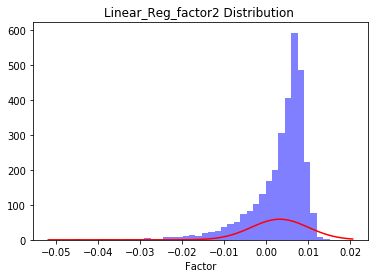

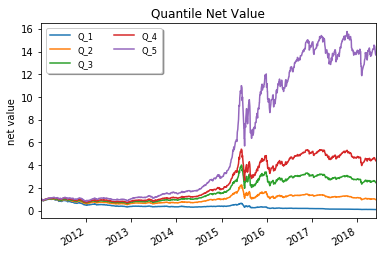

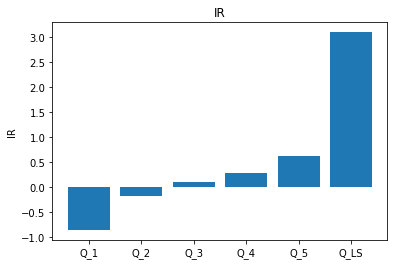

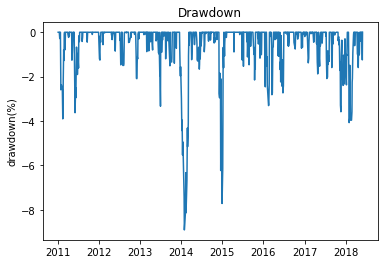

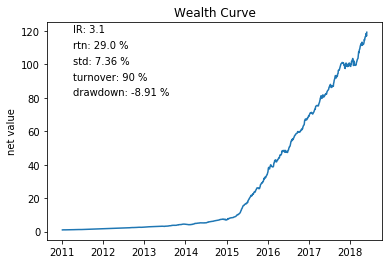

In [27]:
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 2 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 2days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "2DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 2days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_2DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "Linear_Reg_factor2"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

Refer to the Quantile Net Value,we can see that although the net value of Q1-Q4 do not have much difference from the result of 5DFoward data,the top 20% show higher net value. 

As for the drawdown chart, from a common sense, a more frequent trading behavior allows us to monitor the fluctuation of our assets’ net value at a more granular level.

Finally, according to the wealth curve, the 2DForward data has much lower standard deviation, which means that 2DForward return is more stable compared with 2DForward return.

To sum up, the higher the trading frequency is, the more liquidity and probability of capturing arbitrage opportunities we could have. It shows a promising real-field application in HFT.